In [1]:
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from online.envs.bidding_env import BiddingEnv
from definitions import ROOT_DIR, ENV_CONFIG_NAME
import json
from online.envs.environment_factory import EnvironmentFactory
from online.helpers import (
    load_model,
    load_vecnormalize,
)

In [2]:
def getScore_nips(total_conversions, cpa, cpa_constraint):
    beta = 2
    penalty = 1
    if cpa > cpa_constraint:
        coef = cpa_constraint / (cpa + 1e-10)
        penalty = pow(coef, beta)
    return penalty * total_conversions

In [13]:
period = 18
data_path = ROOT_DIR / "data" /"traffic" / "raw_traffic_sparse_parquet" / f"period-{period}.parquet"
raw_df = pd.read_parquet(data_path)
# raw_df
# raw_df["real_cost"] = raw_df["cost"] * raw_df["isExposed"]
# info_df = raw_df.groupby("advertiserNumber").agg({"budget": "mean", "CPAConstraint": "mean", "advertiserCategoryIndex": "mean"}).reset_index()
# info_df
# info_df.to_csv(ROOT_DIR / "data" / "advertiser_info" / "sparse.csv")



In [5]:
# score_list = []
# exp_score_list = []
# for advertiser_id in range(48):
#     total_conversions = raw_df[(raw_df.advertiserNumber == advertiser_id)].conversionAction.sum()
#     exp_total_conversions = raw_df[(raw_df.advertiserNumber == advertiser_id) & (raw_df.isExposed == 1)].pValue.sum()
#     budget = raw_df[(raw_df.advertiserNumber == advertiser_id)].budget.mean()
#     cpa_target = raw_df[(raw_df.advertiserNumber == advertiser_id)].CPAConstraint.mean()
#     total_cost = raw_df[(raw_df.advertiserNumber == advertiser_id) & (raw_df.isExposed == 1)].cost.sum()
#     cpa = total_cost / total_conversions
#     score = getScore_nips(total_conversions, cpa, cpa_target)
#     exp_score = getScore_nips(exp_total_conversions, cpa, cpa_target)
#     score_list.append(score)
#     exp_score_list.append(exp_score)
#     # print(f"Budget: {budget}, Total Cost: {total_cost}, Total Conversions: {total_conversions}, CPA Target: {cpa_target}, CPA: {cpa}, Score: {score}")
# print(np.mean(score_list))
# print(np.mean(exp_score_list))

In [6]:
# plt.plot(score_list, exp_score_list, 'o')
# plt.plot(sorted(score_list), sorted(score_list), 'r')

In [7]:
# model_list = []
# for idx, row in info_df.iterrows():
#     model_list.append({
#         "advertser": int(np.round(row.advertiserNumber)),
#         "category": int(np.round(row.advertiserCategoryIndex)),
#         "budget": int(np.round(row.budget)),
#         "cpa": int(np.round(row.CPAConstraint)),
#     })
# print(model_list)

In [ ]:
pvalues_path = ROOT_DIR / "data" / "traffic" / "online_rl_data_dense" / f"period-{period}_pvalues.parquet"
bids_path = ROOT_DIR / "data" / "traffic" / "online_rl_data_dense" / f"period-{period}_bids.parquet"
budget_range = (2000, 5000)
target_cpa_range = (60, 130)
seed = 0
with open(ROOT_DIR / "data" / "obs_configs" / f"obs_60_keys.json", "r") as f:
    obs_keys = json.load(f)
env = BiddingEnv(pvalues_path, bids_path, budget_range, target_cpa_range, obs_keys=obs_keys, exclude_self_bids=True, 
                 seed=seed, deterministic_conversion=False, single_io_bid=False, oracle_upgrade=True,
                 stochastic_exposure=False)

Loading pvalues from /home/ubuntu/Dev/NeurIPS_Auto_Bidding_General_Track_Baseline/data/traffic/online_rl_data_dense/period-18_pvalues.parquet


Loading bids from /home/ubuntu/Dev/NeurIPS_Auto_Bidding_General_Track_Baseline/data/traffic/online_rl_data_dense/period-18_bids.parquet


/tmp/ipykernel_681391/2321435957.py:5: RuntimeWarning: divide by zero encountered in log
  return np.log(alpha)


Real Conversions: 80.0, Simulated Conversions: 91


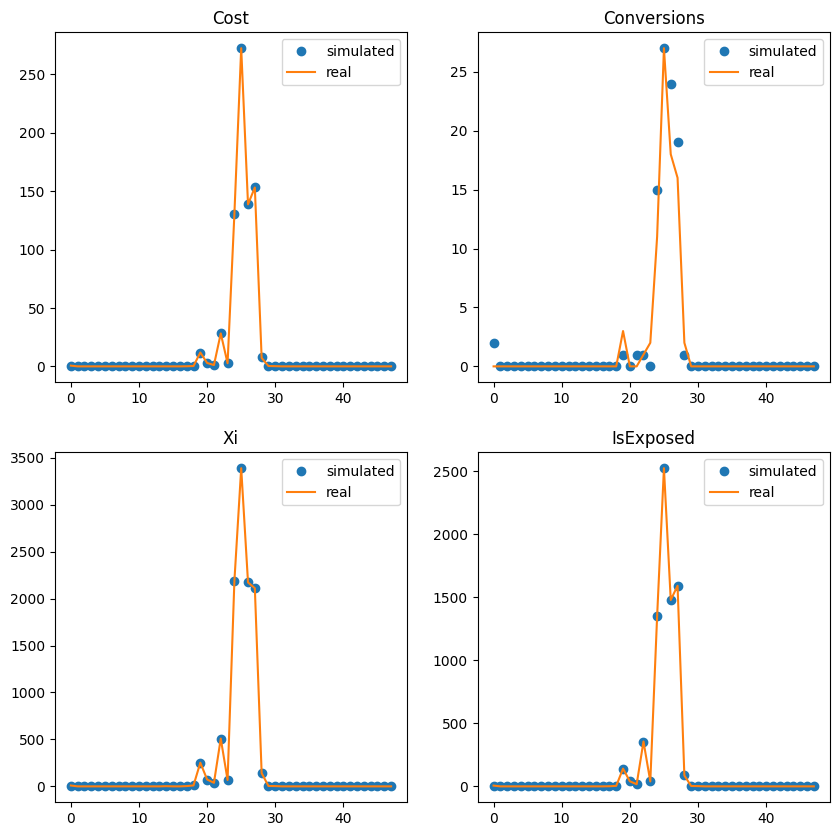

80.0 91.0


In [14]:
def compute_alpha(ad_df, ts, target_cpa):
    bids = ad_df[ad_df.timeStepIndex == ts].bid.to_numpy()
    pvalues = ad_df[ad_df.timeStepIndex == ts].pValue.to_numpy()
    alpha = np.nanmean(bids[pvalues > 0] / pvalues[pvalues > 0]) / target_cpa
    return np.log(alpha)

sim_conv_list = []
real_conv_list = []
for advertiser_id in range(0, 1):
    ad_df = raw_df[raw_df.advertiserNumber == advertiser_id]

    campaign_df = ad_df.groupby("timeStepIndex").agg({
        "real_cost": "sum",
        "conversionAction": "sum",
        "xi": "sum",
        "isExposed": "sum",
        "remainingBudget": "mean"})

    ad_info = info_df[info_df.advertiserNumber == advertiser_id]
    budget = ad_info["budget"].item()
    target_cpa = ad_info["CPAConstraint"].item()

    obs, _ = env.reset(budget=budget, target_cpa=target_cpa, advertiser=advertiser_id)

    done = False
    while not done:
        step_info = campaign_df[campaign_df.index == env.time_step]
        alpha = compute_alpha(ad_df, env.time_step, target_cpa)
        obs, reward, terminated, truncated, info = env.step(alpha)
        done = terminated or truncated

    # # Make 4 subplots for cost, conversions, xi, and isExposed
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    axs[0, 0].plot(env.history_info["cost_sum"], "o", label="simulated")
    axs[0, 0].plot(campaign_df.real_cost.to_numpy(), label="real")
    axs[0, 0].set_title("Cost")
    axs[0, 0].legend()
    axs[0, 1].plot(env.history_info["conversion_count"], "o", label="simulated")
    axs[0, 1].plot(campaign_df.conversionAction.to_numpy(), label="real")
    axs[0, 1].set_title("Conversions")
    axs[0, 1].legend()
    axs[1, 0].plot(env.history_info["bid_success_count"], "o", label="simulated")
    axs[1, 0].plot(campaign_df.xi.to_numpy(), label="real")
    axs[1, 0].set_title("Xi")
    axs[1, 0].legend()
    axs[1, 1].plot(env.history_info["exposure_count"], "o", label="simulated")
    axs[1, 1].plot(campaign_df.isExposed.to_numpy(), label="real")
    axs[1, 1].set_title("IsExposed")
    axs[1, 1].legend()

    # Compare number of conversions
    real_conversions = campaign_df.conversionAction.sum()
    sim_conversions = np.sum(env.history_info["conversion_count"])
    real_conv_list.append(real_conversions)
    sim_conv_list.append(sim_conversions)
    print(f"Real Conversions: {real_conversions}, Simulated Conversions: {sim_conversions}")
    plt.show()
print(np.mean(real_conv_list), np.mean(sim_conv_list))


In [9]:
path = "/home/ubuntu/Dev/NeurIPS_Auto_Bidding_General_Track_Baseline/data/traffic/offline_rl_data_sparse/period-27_27_offline_rl_data.parquet"
df = pd.read_parquet(path)
df.shape

(2304, 15)

In [12]:
df

,deliveryPeriodIndex,advertiserNumber,advertiserCategoryIndex,budget,CPAConstraint,realAllCost,realAllConversion,timeStepIndex,state,action,reward,reward_continuous,done,oracle_action,next_state
0,27,0,0.0,2900.0,100.0,0.509104,0,0,"[1.0, 1.0, 2900.0, 100.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,0.0,0.0,False,-0.420771,"[0.9791666865348816, 0.9998244643211365, 2900...."
1,27,0,0.0,2900.0,100.0,0.000000,0,1,"[0.9791666865348816, 0.9998244643211365, 2900....",0.000000,0.0,0.0,False,-0.420808,"[0.9583333134651184, 0.9998244643211365, 2900...."
2,27,0,0.0,2900.0,100.0,0.000000,0,2,"[0.9583333134651184, 0.9998244643211365, 2900....",0.000000,0.0,0.0,False,-0.420808,"[0.9375, 0.9998244643211365, 2900.0, 100.0, 0...."
3,27,0,0.0,2900.0,100.0,0.000000,0,3,"[0.9375, 0.9998244643211365, 2900.0, 100.0, 0....",0.000000,0.0,0.0,False,-0.420808,"[0.9166666865348816, 0.9998244643211365, 2900...."
4,27,0,0.0,2900.0,100.0,0.000000,0,4,"[0.9166666865348816, 0.9998244643211365, 2900....",0.000000,0.0,0.0,False,-0.420808,"[0.8958333134651184, 0.9998244643211365, 2900...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2299,27,47,5.0,2050.0,120.0,0.000000,0,43,"[0.1041666641831398, 0.7164538502693176, 2050....",-0.399932,0.0,0.0,False,0.527028,"[0.0833333358168602, 0.7164538502693176, 2050...."
2300,27,47,5.0,2050.0,120.0,0.000000,0,44,"[0.0833333358168602, 0.7164538502693176, 2050....",-0.245841,0.0,0.0,False,0.552255,"[0.0625, 0.7164538502693176, 2050.0, 120.0, 5...."
2301,27,47,5.0,2050.0,120.0,29.514430,1,45,"[0.0625, 0.7164538502693176, 2050.0, 120.0, 5....",-0.003277,0.0,1.0,False,0.579560,"[0.0416666679084301, 0.7020565867424011, 2050...."
2302,27,47,5.0,2050.0,120.0,61.626053,0,46,"[0.0416666679084301, 0.7020565867424011, 2050....",0.405465,0.0,0.0,False,0.776274,"[0.02083333395421505, 0.6719951033592224, 2050..."


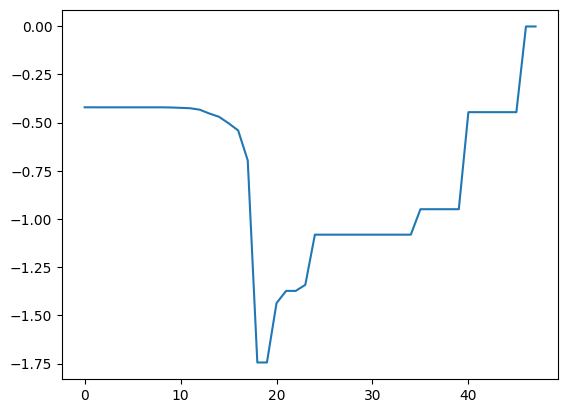

In [11]:
plt.plot(df[df.advertiserNumber == 0].oracle_action)

In [11]:
advertiser_id = 18
ts = 10
env.reset(advertiser=advertiser_id, budget=2000, target_cpa=100)
pvalues = env.episode_pvalues_df[env.episode_pvalues_df.timeStepIndex == ts].pValue.item()

ad_df = raw_df[raw_df.advertiserNumber == advertiser_id]
pvalues_origin = ad_df[ad_df.timeStepIndex == ts].pValue.to_numpy()

In [13]:
# np.mean(pvalues_origin), np.mean(pvalues)

In [14]:
exp_path = "053_onbc_seed_0_new_data_realistic_60_obs_resume_050"
checkpoint = 13170000

experiment_path = ROOT_DIR / "output" / "training" / "challenge" / exp_path
model = load_model(
    "oil",
    experiment_path,
    checkpoint,
)
train_env_config = json.load(open(experiment_path / ENV_CONFIG_NAME, "r"))
train_env_config["bids_df_path"] = None
train_env_config["pvalues_df_path"] = None
train_env = EnvironmentFactory.create(**train_env_config)
vecnormalize = load_vecnormalize(experiment_path, checkpoint, train_env)
vecnormalize.training = False


/home/ubuntu/miniforge3/envs/alibaba/lib/python3.9/site-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment BiddingEnv-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


TypeError: __init__() got an unexpected keyword argument 'new_action' was raised from the environment creator for BiddingEnv-v0 with kwargs ({'pvalues_df_path': None, 'bids_df_path': None, 'budget_range': [1000.0, 6000.0], 'target_cpa_range': [50.0, 150.0], 'rwd_weights': {'dense': 1, 'sparse': 0}, 'new_action': True, 'multi_action': False, 'exp_action': True, 'obs_keys': ['time_left', 'budget_left', 'budget', 'cpa', 'category', 'historical_bid_mean', 'last_bid_mean', 'last_three_bid_mean', 'least_winning_cost_mean', 'last_least_winning_cost_mean', 'last_three_least_winning_cost_mean', 'least_winning_cost_10_pct', 'last_least_winning_cost_10_pct', 'last_three_least_winning_cost_10_pct', 'least_winning_cost_01_pct', 'last_least_winning_cost_01_pct', 'last_three_least_winning_cost_01_pct', 'pvalues_mean', 'conversion_mean', 'bid_success_mean', 'last_pvalues_mean', 'last_three_pvalues_mean', 'last_conversion_mean', 'last_three_conversion_mean', 'last_bid_success', 'last_three_bid_success_mean', 'historical_successful_bid_position_mean', 'last_successful_bid_position_mean', 'last_three_successful_bid_position_mean', 'historical_cost_mean', 'last_cost_mean', 'last_three_cost_mean', 'historical_cost_slot_1_mean', 'last_cost_slot_1_mean', 'last_three_cost_slot_1_mean', 'historical_cost_slot_2_mean', 'last_cost_slot_2_mean', 'last_three_cost_slot_2_mean', 'historical_cost_slot_3_mean', 'last_cost_slot_3_mean', 'last_three_cost_slot_3_mean', 'historical_bid_over_lwc_mean', 'last_bid_over_lwc_mean', 'last_three_bid_over_lwc_mean', 'historical_pv_over_lwc_mean', 'last_pv_over_lwc_mean', 'last_three_pv_over_lwc_mean', 'historical_pv_over_lwc_90_pct', 'last_pv_over_lwc_90_pct', 'last_three_pv_over_lwc_90_pct', 'historical_pv_over_lwc_99_pct', 'last_pv_over_lwc_99_pct', 'last_three_pv_over_lwc_99_pct', 'current_pvalues_mean', 'current_pvalues_90_pct', 'current_pvalues_99_pct', 'current_pv_num', 'last_pv_num', 'last_three_pv_num', 'pv_num_total'], 'act_keys': ['pvalue'], 'sample_log_budget': False, 'simplified_bidding': False, 'stochastic_exposure': False, 'auction_noise': 0.0, 'pvalues_rescale_range': [1.0, 1.0], 'simplified_exposure_prob_range': [1.0, 1.0], 'simplified_oracle': False, 'exclude_self_bids': False, 'oracle_upgrade': False, 'two_slopes_action': False, 'seed': 0})

In [10]:
advertiser_id = 8

ad_df = raw_df[raw_df.advertiserNumber == advertiser_id]

campaign_df = ad_df.groupby("timeStepIndex").agg({
    "real_cost": "sum",
    "conversionAction": "sum",
    "xi": "sum",
    "isExposed": "sum",
    "remainingBudget": "mean"})

ad_info = info_df[info_df.advertiserNumber == advertiser_id]
budget = ad_info["budget"].item()
target_cpa = ad_info["CPAConstraint"].item()

obs, _ = env.reset(budget=budget, target_cpa=target_cpa, advertiser=advertiser_id)

done = False
while not done:
    pvalues, pvalue_sigmas = env.unwrapped.get_pvalues_mean_and_std()
    state_dict = env.unwrapped.get_state_dict(pvalues, pvalue_sigmas)
    state = train_env.unwrapped.get_state(state_dict)
    norm_obs = vecnormalize.normalize_obs(state)
    action, _ = model.predict(
        norm_obs,
        deterministic=True,
    )
    bid_coef = train_env.unwrapped.compute_bid_coef(
        action, pvalues, pvalue_sigmas
    )
    bids = bid_coef * env.unwrapped.target_cpa
    _, reward, terminated, truncated, info = env.unwrapped.place_bids(
        bids, pvalues, pvalue_sigmas
    )
    done = terminated or truncated

# Make 4 subplots for cost, conversions, xi, and isExposed
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].plot(env.history_info["cost_sum"], "o", label="simulated")
axs[0, 0].plot(campaign_df.real_cost.to_numpy(), label="real")
axs[0, 0].set_title("Cost")
axs[0, 0].legend()
axs[0, 1].plot(env.history_info["conversion_count"], "o", label="simulated")
axs[0, 1].plot(campaign_df.conversionAction.to_numpy(), label="real")
axs[0, 1].set_title("Conversions")
axs[0, 1].legend()
axs[1, 0].plot(env.history_info["bid_success_count"], "o", label="simulated")
axs[1, 0].plot(campaign_df.xi.to_numpy(), label="real")
axs[1, 0].set_title("Xi")
axs[1, 0].legend()
axs[1, 1].plot(env.history_info["exposure_count"], "o", label="simulated")
axs[1, 1].plot(campaign_df.isExposed.to_numpy(), label="real")
axs[1, 1].set_title("IsExposed")
axs[1, 1].legend()

# Compare number of conversions
real_conversions = campaign_df.conversionAction.sum()
sim_conversions = np.sum(env.history_info["conversion_count"])
real_conv_list.append(real_conversions)
sim_conv_list.append(sim_conversions)
print(f"Real Conversions: {real_conversions}, Simulated Conversions: {sim_conversions}")

plt.show()


NameError: name 'train_env' is not defined

In [31]:
exp_path = "053_onbc_seed_0_new_data_realistic_60_obs_resume_050"
checkpoint = 13170000
dataset_id = 1

experiment_path = ROOT_DIR / "output" / "training" / "ongoing" / exp_path
model = load_model(
    "onbc",
    experiment_path,
    checkpoint,
)
train_env_config = json.load(open(experiment_path / ENV_CONFIG_NAME, "r"))
train_env_config["bids_df_path"] = None
train_env_config["pvalues_df_path"] = None
train_env = EnvironmentFactory.create(**train_env_config)
vecnormalize = load_vecnormalize(experiment_path, checkpoint, train_env)
vecnormalize.training = False


env path /home/ubuntu/Dev/NeurIPS_Auto_Bidding_General_Track_Baseline/output/training/ongoing/053_onbc_seed_0_new_data_realistic_60_obs_resume_050/rl_model_vecnormalize_13170000_steps.pkl


In [32]:
num_advertisers = 48
num_time_steps = 48
period_list = np.arange(7, 28)

for period in period_list:
    print("Period", period)
    pvalues_path = ROOT_DIR / "data" / "online_rl_data_sparse" / f"period-{period}_pvalues.parquet"
    bids_path = ROOT_DIR / "data" / "online_rl_data_sparse" / f"period-{period}_bids.parquet"
    
    with open(ROOT_DIR / "env_configs" / f"obs_60_keys.json", "r") as f:
        obs_keys = json.load(f)
    env = BiddingEnv(pvalues_path, bids_path, obs_keys=obs_keys, exclude_self_bids=True, 
                    seed=0, simplified_bidding=False, deterministic_conversion=False,
                    stochastic_exposure=False)
    
    bids_per_ts_list = [[] for _ in  range(num_time_steps)]

    for advertiser_id in range(num_advertisers):
        print(f"Advertiser: {advertiser_id}")
        ad_info = info_df[info_df.advertiserNumber == advertiser_id]
        budget = ad_info["budget"].item()
        target_cpa = ad_info["CPAConstraint"].item()

        obs, _ = env.reset(budget=budget, target_cpa=target_cpa, advertiser=advertiser_id)

        done = False
        ts = 0
        while not done:
            pvalues, pvalue_sigmas = env.unwrapped.get_pvalues_mean_and_std()
            state_dict = env.unwrapped.get_state_dict(pvalues, pvalue_sigmas)
            state = train_env.unwrapped.get_state(state_dict)
            norm_obs = vecnormalize.normalize_obs(state)
            action, _ = model.predict(
                norm_obs,
                deterministic=True,
            )
            bid_coef = train_env.unwrapped.compute_bid_coef(
                action, pvalues, pvalue_sigmas
            )
            bids = bid_coef * env.unwrapped.target_cpa
            _, reward, terminated, truncated, info = env.unwrapped.place_bids(
                bids, pvalues, pvalue_sigmas
            )
            bids_per_ts_list[ts].append(bids)
            done = terminated or truncated
            ts += 1
        assert ts == 48, ts
    
    bids_df = env.bids_df_list.copy()
    bids_df.deliveryPeriodIndex += 28 * dataset_id
    
    # Update the dataset with the collected bids
    for ts in range(num_time_steps):
        bids = np.stack(bids_per_ts_list[ts]).transpose()
        sort_idx = np.argsort(bids, axis=1)
        num_impressions = bids.shape[0]

        top_bids_ids = sort_idx[:, -3:]
        top_cost_ids = sort_idx[:, -4:-1]
        top_bids = np.take_along_axis(bids, top_bids_ids, axis=1)
        top_bid_costs = np.take_along_axis(bids, top_cost_ids, axis=1)
        
        # Select rows where timeStepIndex equals current ts
        mask = bids_df.timeStepIndex == ts
        idx = bids_df.index[mask].item()

        bids_df.at[idx, "bid"] = top_bids
        bids_df.at[idx, "cost"] = top_bid_costs
        bids_df.at[idx, "advertiserNumber"] = top_bids_ids
    bids_df["bid"] = bids_df["bid"].apply(lambda x: x.tolist())
    bids_df["cost"] = bids_df["cost"].apply(lambda x: x.tolist())
    bids_df["advertiserNumber"] = bids_df["advertiserNumber"].apply(lambda x: x.tolist())
    # bids_df["conversionAction"] = bids_df["conversionAction"].apply(lambda x: x.tolist())
    bids_df["isExposed"] = bids_df["isExposed"].apply(lambda x: x.tolist())

    out_path = ROOT_DIR / "data" / "online_rl_data_sparse_expert_bids" / f"period-{period}_bids_{dataset_id}.parquet"
    print("Saving to", out_path)
    out_path.parent.mkdir(parents=True, exist_ok=True)
    bids_df.to_parquet(out_path)



Period 7
Loading pvalues from /home/ubuntu/Dev/NeurIPS_Auto_Bidding_General_Track_Baseline/data/online_rl_data_sparse/period-7_pvalues.parquet


Loading bids from /home/ubuntu/Dev/NeurIPS_Auto_Bidding_General_Track_Baseline/data/online_rl_data_sparse/period-7_bids.parquet
Advertiser: 0
Advertiser: 1
Advertiser: 2
Advertiser: 3
Advertiser: 4
Advertiser: 5
Advertiser: 6
Advertiser: 7
Advertiser: 8
Advertiser: 9
Advertiser: 10
Advertiser: 11
Advertiser: 12
Advertiser: 13
Advertiser: 14
Advertiser: 15
Advertiser: 16
Advertiser: 17
Advertiser: 18
Advertiser: 19
Advertiser: 20
Advertiser: 21
Advertiser: 22
Advertiser: 23
Advertiser: 24
Advertiser: 25
Advertiser: 26
Advertiser: 27
Advertiser: 28
Advertiser: 29
Advertiser: 30
Advertiser: 31
Advertiser: 32
Advertiser: 33
Advertiser: 34
Advertiser: 35
Advertiser: 36
Advertiser: 37
Advertiser: 38
Advertiser: 39
Advertiser: 40
Advertiser: 41
Advertiser: 42
Advertiser: 43
Advertiser: 44
Advertiser: 45
Advertiser: 46
Advertiser: 47
Saving to /home/ubuntu/Dev/NeurIPS_Auto_Bidding_General_Track_Baseline/data/online_rl_data_sparse_expert_bids/period-7_bids_1.parquet
Period 8
Loading pvalues fro